# Laboratorio 2: Digit Recognizer

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging 
import os

# Weights and Biases (WandB)
import wandb 
from wandb.keras import WandbCallback

# Test train split
from sklearn.model_selection import train_test_split

# Keras
# NOTA: No mezclar imports de tensorflow y keras para definiciones de
# capa u optimizadores. Al compilar el modelo va a dar error.
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import adam_v2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten

## Setup Previo (WandB)

In [2]:
# Se eliminan los mensajes excesivos de WandB limitándolo a 
# que solo notifique errores que ocurran durante la ejecución.
logger = logging.getLogger("wandb")
logger.setLevel(logging.INFO)

# Se le da un nombre al notebook actual dentro de WandB
os.environ["WANDB_NOTEBOOK_NAME"] = "Laboratorio 2.ipynb"

## Carga y Split de Datos

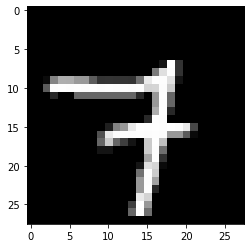

In [4]:
# Se convierte el CSV en un dataframe 
df = pd.read_csv("train.csv")

# Se separan los datos en labels y entradas
y_data = df["label"].to_numpy() 
X_data = df.iloc[:,1:].to_numpy() 

# Se extraen los datos de Test
# Test: 20% del dataset
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=69)

# Se obtienen los datos de Train y Validación
# Validation: 10% del dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=69)

# Los datos se redimensionan para tener una fila por imagen y en
# las dos dimensiones restantes una imagen de 28x28
X_train = np.reshape(X_train, (-1, 28, 28, 1))
X_test = np.reshape(X_test, (-1, 28, 28, 1))
X_valid = np.reshape(X_valid, (-1, 28, 28, 1))

# Dado que la predicción final se realizará utilizando 10 neuronas softmax, 
# las labels deben ser codificadas utilizando one hot encoding. 
# NOTA: No necesario si se utiliza "sparse_categorical_crossentropy" abajo.
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y_valid = to_categorical(y_valid)

# Si no se utilizan el OHE anterior, las labels se redimensionan para ser bidimensionales
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
y_valid = np.reshape(y_valid, (-1, 1))

# Se extraen las labels del dataset en string
labels = list(np.unique(y_train).astype(str))

# Revisar que el redimensionamiento haya sido exitoso
plt.imshow(X_train[0,:,:,0], cmap="gray")
plt.show()

## Data Expansion

Normalmente aquí se realizaría una acción para aumentar los datos, pero en este caso se debe ser muy cuidadoso, ya que las imágenes de dígitos no pueden "flipearse" o rotarse mucho. La razón para esto es que si rotamos mucho un "6", por ejemplo, este comenzará a verse como un "9". Para evitar esto, el aumentado de datos debe realizarse de forma conservadora. Las operaciones aplicadas en este caso serían: corte, normalización, rotación leve y zoom. 

In [11]:
# Generador genera de forma dinámica nuevas muestras con
# los efectos especificados aplicados.
datagen = ImageDataGenerator(
    rescale = 1/255.,
    shear_range=0.05,
    zoom_range=0.05,
    rotation_range=3
)

# Para utilizar el generador usar el siguiente comando:
train_gen = datagen.flow(X_train, y_train, batch_size=32)
test_gen = datagen.flow(X_test, y_test, batch_size=32)

## Modelo: Red Neuronal Simple

Red neuronal sin cualidades convolucionales. Los pixeles de las imágenes se tratan como listas de valores.

In [13]:
# WandB: 0. Loggearse en Weights and Biases (solo la primera vez que se descarga)
# wandb.login()

# WandB: 1. Se declara un nuevo run. Se declaran las configuraciones a trackear
run = wandb.init(project="Text_Mining-Lab2", entity="sanoli",
                 config={
                    "learning_rate": 0.001, 
                    "epochs": 10, 
                    "batch_size": 32,  
                    "loss_function": "sparse_categorical_crossentropy",  
                    "architecture": "NN",  
                    "dataset": "MNIST"
                 })

# NOTAS:
# - loss_function: Debe ser sparse si las labels no tienen one hot encoding.
#                  Si no tienen OHE, entonces utilizar "categorical_crossentropy"

# Estructura base de la red (una capa detrás de la otra)
nn = Sequential()

# Inicializador de pesos de la red
# Se utilizará el de glorot, también conocido como el de Xavier
initializer = keras.initializers.GlorotNormal()

# Se adicionan capas a la red
# 1. Flatten: Se crea un solo vector para la imagen de 28x28. None para aceptar cuantas imágenes se necesiten
# 2. Dense: Capas densas de dimensiones en decremento para "comprimir" la información
# 3. Dense: 10 neuronas de salida para clasificación multiclase (softmax). 
nn.add(Flatten(input_shape=(28, 28, 1)))
nn.add(Dense(units=256, activation="relu", kernel_initializer=initializer))
nn.add(Dense(units=128, activation="relu", kernel_initializer=initializer))
nn.add(Dense(units=64, activation="relu", kernel_initializer=initializer))
nn.add(Dense(units=10, activation="softmax"))

# WandB: 2. Guarda los inputs e hiperparámetros del modelo
config = wandb.config

# Se selecciona el optimizador
optimizer = adam_v2.Adam(learning_rate=config.learning_rate)

# Se compila el modelo
nn.compile(optimizer=optimizer, loss=config.loss_function, metrics=["accuracy"])

# Se entrena el modelo 
nn.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_valid, y_valid), 
       callbacks=[
            # Se envían datos a weights and biases
            WandbCallback(
                data_type="image",                      # Se generan imágenes en el reporte
                monitor="accuracy",                     # Monitorea el accuracy como métrica
                mode="max",                             # Trackea aumentos en accuracy
                save_model=True,                        # Guardar modelo cuando se alcanza un nuevo máximo en accuracy
                validation_data=(X_valid, y_valid),     # WandB hace predicciones a medio proceso y las despliega en el dashboard
                labels=labels,                          # Se declaran las labels que se van a predecir
                predictions=10                          # Número de predicciones a generar
            ),          
       ])

# Se mide la precisión con set pruebas
loss, accuracy = nn.evaluate(X_test, y_test)
print(f"Test Error Rate: {round((1-accuracy)*100, 2)}")

# Se loguean los resultados en WandB
wandb.log({"Test Error Rate" : round((1-accuracy)*100, 2)})
run.join()

# Se finaliza el "run" de WandB
run.finish()

wandb: ERROR Control-C detected -- Run data was not synced


Epoch 1/10
945/945 [==============================] - 4s 4ms/step - loss: 1.6834 - accuracy: 0.8586 - val_loss: 0.4581 - val_accuracy: 0.9089
Epoch 2/10
945/945 [==============================] - 4s 4ms/step - loss: 0.2878 - accuracy: 0.9319 - val_loss: 0.3321 - val_accuracy: 0.9271
Epoch 3/10
945/945 [==============================] - 3s 3ms/step - loss: 0.1953 - accuracy: 0.9485 - val_loss: 0.2797 - val_accuracy: 0.9351
Epoch 4/10
945/945 [==============================] - 3s 3ms/step - loss: 0.1746 - accuracy: 0.9529 - val_loss: 0.2299 - val_accuracy: 0.9464
Epoch 5/10
945/945 [==============================] - 3s 3ms/step - loss: 0.1455 - accuracy: 0.9607 - val_loss: 0.2171 - val_accuracy: 0.9417
Epoch 6/10
945/945 [==============================] - 3s 3ms/step - loss: 0.1269 - accuracy: 0.9649 - val_loss: 0.2902 - val_accuracy: 0.9420
Epoch 7/10
945/945 [==============================] - 3s 3ms/step - loss: 0.1242 - accuracy: 0.9650 - val_loss: 0.1968 - val_accuracy: 0.9527
Epoch 

epoch,9
loss,0.08212
accuracy,0.97728
val_loss,0.17767
val_accuracy,0.95774
_runtime,39
_timestamp,1631423773
_step,10
best_accuracy,0.97728
best_epoch,9
Test Error Rate,4.29


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▄▂▂▄▁▁▁▁
val_accuracy,▁▄▅▆▆▆▇█▇█
_runtime,▁▂▃▄▄▅▆▆▇██
_timestamp,▁▂▃▄▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
Test Error Rate,▁


## Modelo: Red Neuronal Convolucional

Red neuronal convolucional. Las imágenes se alimentan directamente a la red en sus dimensiones originales.

In [15]:
# WandB: 1. Se declara un nuevo run. Se declaran las configuraciones a trackear
run = wandb.init(project="Text_Mining-Lab2", entity="sanoli",
                 config={
                    "learning_rate": 0.001, 
                    "epochs": 10, 
                    "batch_size": 32,  
                    "loss_function": "sparse_categorical_crossentropy",  
                    "architecture": "CNN",  
                    "dataset": "MNIST"
                 })

# NOTAS:
# - loss_function: Debe ser sparse si las labels no tienen one hot encoding.
#                  Si no tienen OHE, entonces utilizar "categorical_crossentropy"

# Estructura base de la red (una capa detrás de la otra)
cnn = Sequential()

# Inicializador de pesos de la red
# Se utilizará el de glorot, también conocido como el de Xavier
initializer = keras.initializers.GlorotNormal()

# Se adicionan capas a la red
# 1. Conv2D + MaxPool2D: Se convoluciona la imagen y se le aplica max pooling para "comprimir" información
# 2. Flatten: Se aplanan las matrices bidimensionales resultantes de la etapa convolucional
# 2. Dense: Capas densas de dimensiones en decremento para "comprimir" la información
# 3. Dense: 10 neuronas de salida para clasificación multiclase (softmax). 
cnn.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(units=256, activation="relu", kernel_initializer=initializer))
cnn.add(Dense(units=128, activation="relu", kernel_initializer=initializer))
cnn.add(Dense(units=64, activation="relu", kernel_initializer=initializer))
cnn.add(Dense(units=10, activation="softmax"))

# WandB: 2. Guarda los inputs e hiperparámetros del modelo
config = wandb.config

# Se selecciona el optimizador
optimizer = adam_v2.Adam(learning_rate=config.learning_rate)

# Se compila el modelo
cnn.compile(optimizer=optimizer, loss=config.loss_function, metrics=["accuracy"])

# Se entrena el modelo 
cnn.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_data=(X_valid, y_valid), 
       callbacks=[
            # Se envían datos a weights and biases
            WandbCallback(
                data_type="image",                      # Se generan imágenes en el reporte
                monitor="accuracy",                     # Monitorea el accuracy como métrica
                mode="max",                             # Trackea aumentos en accuracy
                save_model=True,                        # Guardar modelo cuando se alcanza un nuevo máximo en accuracy
                validation_data=(X_valid, y_valid),     # WandB hace predicciones a medio proceso y las despliega en el dashboard
                labels=labels,                          # Se declaran las labels que se van a predecir
                predictions=10                          # Número de predicciones a generar
            ),          
       ])

# Se mide la precisión con set pruebas
loss, accuracy = cnn.evaluate(X_test, y_test)
print(f"Test Error Rate: {round((1-accuracy)*100, 2)}")

# Se loguean los resultados en WandB
wandb.log({"Test Error Rate" : round((1-accuracy)*100, 2)})
run.join()

# Se finaliza el "run" de WandB
run.finish()

Epoch 1/10
945/945 [==============================] - 15s 15ms/step - loss: 0.3756 - accuracy: 0.9172 - val_loss: 0.1574 - val_accuracy: 0.9476
Epoch 2/10
945/945 [==============================] - 15s 16ms/step - loss: 0.0943 - accuracy: 0.9712 - val_loss: 0.1245 - val_accuracy: 0.9625
Epoch 3/10
945/945 [==============================] - 14s 14ms/step - loss: 0.0700 - accuracy: 0.9788 - val_loss: 0.0942 - val_accuracy: 0.9735
Epoch 4/10
945/945 [==============================] - 14s 15ms/step - loss: 0.0572 - accuracy: 0.9825 - val_loss: 0.1302 - val_accuracy: 0.9643
Epoch 5/10
945/945 [==============================] - 14s 15ms/step - loss: 0.0515 - accuracy: 0.9848 - val_loss: 0.0666 - val_accuracy: 0.9786
Epoch 6/10
945/945 [==============================] - 14s 15ms/step - loss: 0.0437 - accuracy: 0.9871 - val_loss: 0.0800 - val_accuracy: 0.9804
Epoch 7/10
945/945 [==============================] - 14s 15ms/step - loss: 0.0393 - accuracy: 0.9885 - val_loss: 0.0722 - val_accuracy:

epoch,9
loss,0.02859
accuracy,0.99213
val_loss,0.09511
val_accuracy,0.97768
_runtime,150
_timestamp,1631425121
_step,10
best_accuracy,0.99213
best_epoch,9
Test Error Rate,1.76


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▂▂▁▁▁▁▁▁
accuracy,▁▆▇▇▇█████
val_loss,█▆▃▆▁▂▂▃▁▃
val_accuracy,▁▄▆▄▇▇█▇█▇
_runtime,▁▂▃▃▄▅▆▆▇██
_timestamp,▁▂▃▃▄▅▆▆▇██
_step,▁▂▂▃▄▅▅▆▇▇█
Test Error Rate,▁


## Conclusiones

Al finalizar el proceso de entrenamiento de ambos tipos de red neuronal (NN y CNN) se llegó a determinar que aunque ambas contaban con una precisión muy alta, la red neuronal convolucional consiguió obtener una ventaja ligeramente mayor por sobre la red neuronal tradicional.

<img src="imgs/test_error_rate.png" alt="test_error" width="500">
<img src="imgs/val_accuracy.png" alt="test_error" width="500">

Como se puede observar en los gráficos anteriores, la corrida que fue realizada con la red convolucional (de color rojo), obtuvo no solo una precisión de evaluación más alta (val_accuracy) a lo largo de todo el entrenamiento, si no que también obtuvo un error de precisión (Test Error Rate) ligeramente más bajo a comparación de todas las demás corridas. Dado que las demás corridas corresponden al modelo con redes neuronales tradicionales, se puede establecer que las redes convolucionales obtuvieron resultados buenos, pero nunca tan buenos como las redes convolucionales. Curiosamente, el punteo de evaluación y de entrenamiento en ambas redes, siempre se encontraban súmamente cercanos entre si, lo que implica que probablemente se le podría agregar un poco más de capacidad al modelo y este podrá alcanzar resultados mejores. Para verificar esto, se agregó una capa adicional al modelo convolucional y se observaron los resultados. Al analizar los resultados (barra verde o "celestial-violet-19") se llegó a evidenciar que efectivamente, el porcentaje de error se había reducido ligeramente.

<img src="imgs/test_error_rate2.png" alt="test_error" width="500">
